# Tracing directors' career journeys using time series data
*Julie Nguyen, PhD candidate in Management (Organizational Behavior), McGill University*

Welcome to another chapter of our exploration of how social networks influence the careers of movie directors. Our journey so far has taken us through identifying our sample of directors (`Phase_1_Tracking_Movie_Directors_Career.ipynb`), mapping the collaboration networks within the film industry and calculated the annual social capital of every creative worker (`Phase_2_Constructing_Filmmaker_Network.ipynb`), and predicting the genders of our directors (`Phase_3_Predicting_Director_Gender.ipynb`).

**What are we aiming to do?**

Our next step is to delve into how a director's career unfolds over time. To do this, we're constructing two types of datasets:
- Longitudinal Dataset (`directors_years`): This tracks the career progression of each director year by year from their debut to 2023. This dataset varies in length for each director, ranging from 11 to 21 years, depending on their debut year between 2003 and 2013.
- Cross-sectional Dataset (`directors_cross_sectional`): This dataset summarizes the outcomes of each director's initial 11 years in the industry.

These datasets help us separate the influence of a director's own social capital from that of their collaborators:
- The longitudinal dataset allows us to see how changes in the social capital of collaborators over time might influence a director's career path.
- The cross-sectional dataset focuses on collaborators' social capital when the director first entered the industry and have minimal social capital themselves, thus highlighting the impact of their collaborators.

**How do we do this?**

1. Constructing time series data: Each row in this dataset represents one year in a director's career, from debut to 2023. We include variables such as:
- Annual directorial engagement: Indicates whether a director has directed a film in a given year, showing if they are still active.
- Dropout indicator: Shows if a director has not directed any films in the past 10 years, signaling a possible end to their directing activities.
- Survival analysis variables (`start_time` and `stop_time`): These measure how long directors remain active, focusing on their career phases rather than calendar years.

2. Constructing cross-sectional data: This dataset compiles key aspects of each director's first 11 years post-debut. Variables include:
- Total movies directed: The total number of movies a director made post-debut.
- Career continuation indicator: Whether the director has continued making films during this period.
- Time to Second Movie: The elapsed time between a director’s first and second movie (if exists).

**Looking ahead**

By the end of this notebook, we will have compiled detailed datasets tracking each director's career trajectory, both annually and across their initial decade in the industry. These datasets will serve as the foundation for our upcoming analyses, where we will explore how factors like network connections and gender impact career paths in the film industry.

# Constructing a time series dataset 

In this part of our analysis, we construct the `directors_years` DataFrame. This is a structured timeline that captures the career trajectory of film directors on an annual basis, from their debut year up to the year 2023. Each row in the data represents a single year in the career of a director. Columns include:
- `nconst_director`: A unique identifier for each director.
- `year`: The specific year being considered for that director's career.
- `debut_year`: The year when the director made their debut.

**Source data**

For this task, we use the `directors_full_filmography` dataset, which we created in a previous notebook (`Phase_1_Tracking_Movie_Directors_Career.ipynb`). This dataset catalogs all films directed by 63,169 directors in our study, with each row associating a director (`nconst`) with a movie (`tconst`) they made.

**Defining the study period**

Since our sample of directors made their debut between 2003 and 2013, our career tracking will span from 2003 to 2023. This period is specifically chosen to ensure that we have at least ten years of follow-up data after each director's debut, facilitating a robust long-term analysis of career trajectories.

**Creating a year-by-year framework**

To effectively track each director's activity:
- We first generate all possible combinations of directors and years within our defined range. This exhaustive approach ensures we capture every year of a director's career from their debut to 2023, even if they did not release any movies in some years. 
- Next, for each director we'll exclude years before they began directing. This way, we don't waste time looking at years before they started their directing career.

In [2]:
# Importing necessary libraries for data manipulation and handling
import pandas as pd  # data manipulation
import os  # interacting with the operating system, such as file paths
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from lifelines import KaplanMeierFitter

# Set the working directory to where the project files are located
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

In [3]:
# Load the filmography dataset for movie directors (2003-2023)
directors_full_filmography = pd.read_csv('directors_full_filmography.csv')

# Display the initial rows of the dataset to understand its structure
directors_full_filmography.head()

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004.0,"Comedy,Mystery",nm1131265,2004.0,7.8,34.0
1,tt0108549,2004.0,"Comedy,Mystery",nm1130611,2004.0,7.8,34.0
2,tt0117461,2003.0,"Comedy,Romance",nm0290651,2003.0,6.3,24.0
3,tt0117743,2008.0,"Drama,Romance",nm0404033,2003.0,6.7,64.0
4,tt0118141,2005.0,Drama,nm0000417,2005.0,5.3,950.0


In [4]:
# Convert the 'startYear' column to integer values 
directors_full_filmography['startYear'] = directors_full_filmography['startYear'].astype(int)

# Identify unique directors and define the range of years for our analysis (2003-2023)
# This range is chosen based on the debut years of directors being studied (2003-2013), extending to 2023 for a long-term look at their careers
directors = directors_full_filmography['nconst'].unique()
years = range(2003, 2024) 

# Generate all possible director-year combinations within the specified range
# This creates a framework to examine each director's career on a yearly basis
directors_years = pd.DataFrame([(director, year) for director in directors for year in years], columns=['nconst', 'year'])

# Merge the generated combinations with the original filmography data to include each director's debut year
# This allows us to filter combinations to only include years after each director's debut
directors_years = directors_years.merge(directors_full_filmography[['nconst', 'firstYear']].drop_duplicates(), on='nconst', how='left')

# Filter out rows that represent years before a director's debut, ensuring the dataset only contains relevant director-year pairs
directors_years = directors_years[directors_years['year'] >= directors_years['firstYear']].drop(columns=['firstYear'])
directors_years.rename(columns={'nconst': 'nconst_director'}, inplace=True)

# Identify the debut year for each director
debut_years = directors_years.groupby('nconst_director')['year'].min().reset_index()
debut_years.rename(columns={'year': 'debut_year'}, inplace=True)

# Merge the debut year back into the directors_years dataset to add a debut_year column
directors_years = pd.merge(directors_years, debut_years, on='nconst_director', how='left')

In [5]:
directors_years.head(21)

,nconst_director,year,debut_year
0,nm1131265,2004,2004
1,nm1131265,2005,2004
2,nm1131265,2006,2004
3,nm1131265,2007,2004
4,nm1131265,2008,2004
5,nm1131265,2009,2004
6,nm1131265,2010,2004
7,nm1131265,2011,2004
8,nm1131265,2012,2004
9,nm1131265,2013,2004


Everything is in order! Now we can move on to adding variables indicating career longevity (our outcome variables) to our time series dataset.

# Creating outcome variables for time series data

In this segment of the analysis, we'll create two crucial outcome variables that will help us measure each director's career trajectory and add them to the `directors_years` dataset:

1. Active Engagement (`made_movie`): This binary indicator specifies whether a director released at least one movie in a given year. This provides a direct measure of a director's active engagement in directing during each year of their career. Notably, for a director's debut year, we set this indicator to zero, ensuring that our analysis focuses on activity after their debut.

2. Career Continuity (`dropout`): This variable indicates whether a director potentially dropped out of directing in a given year. We determine this by identifying the last year in which directors released a movie. Directors who have not released any movies since 2013 (the last decade of the observation period) are considered to have potentially dropped out. Conversely, for directors who were active after 2013, we do not specify a dropout year, implying continued involvement in the industry.

As we gear up for survival analysis, let's also create 

3. Relative Career Timing (`start_time` and `stop_time`): These variables are essential for survival analysis, as they allow us to measure the duration of directors' active phases. We calculate these timing variables relative to each director's debut year. This approach allows us to standardize the career timeline across our sample, focusing on the progression and duration of directors' careers without the variability introduced by different debut years.

By the end, we should have a dataset where each row represents a single year in the career of a director, with the following columns:
- `nconst_director`: A unique identifier for each director.
- `year`: The specific year being considered for that director's career.
- `debut_year`: The year when the director made their debut.
- `num_movies`: The number of movies released by the director in that particular year.
- `made_movie`: A binary indicator stating whether the director released any movies in that year (1 if yes, 0 if no).
- `dropoutYear`: A time-invariant variable indicating year the director potentially dropped out, assiged as missing value if the director is still active
- `dropout`: Indicates whether the director is considered to have potentially dropped out of the industry by that year.
- `start_time` and `stop_time`: The relative start and stop times from each director's debut year.

Let's start with creating a binary indicator (`made_movie`) to identify whether a director was active in a given year.

In [5]:
# taking a look at the director filmography data to figure out how to create outcome variables
directors_full_filmography.head()

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004,"Comedy,Mystery",nm1131265,2004.0,7.8,34.0
1,tt0108549,2004,"Comedy,Mystery",nm1130611,2004.0,7.8,34.0
2,tt0117461,2003,"Comedy,Romance",nm0290651,2003.0,6.3,24.0
3,tt0117743,2008,"Drama,Romance",nm0404033,2003.0,6.7,64.0
4,tt0118141,2005,Drama,nm0000417,2005.0,5.3,950.0


In [6]:
# Aggregate the director's filmography data to count unique movies released by each director per year.
movies_released_per_year = directors_full_filmography.groupby(['nconst', 'startYear'])['tconst'].nunique().reset_index()

# Rename columns for clarity: director ID as 'nconst_director', release year as 'year', and number of movies as 'num_movies'.
movies_released_per_year.rename(columns={'nconst': 'nconst_director', 'startYear': 'year', 'tconst': 'num_movies'}, inplace=True)

# Merge the yearly movie release counts with the main dataset to include the number of movies each director released each year.
directors_years = directors_years.merge(movies_released_per_year, on=['nconst_director', 'year'], how='left')

# Replace missing values in 'num_movies' with 0, indicating no movies were released by the director in those years.
directors_years['num_movies'] = directors_years['num_movies'].fillna(0)

# Create a binary indicator 'made_movie' to denote whether the director released any movies in a given year (1 if yes, 0 if no).
directors_years['made_movie'] = (directors_years['num_movies'] > 0).astype(int)

# For the director's debut year, set 'num_movies' and 'made_movie' to 0 so that the variables reflect activity after debut
directors_years.loc[directors_years['year'] == directors_years['debut_year'], ['num_movies', 'made_movie']] = 0

In [7]:
directors_years.head(21)

,nconst_director,year,debut_year,num_movies,made_movie
0,nm1131265,2004,2004,0.0,0
1,nm1131265,2005,2004,0.0,0
2,nm1131265,2006,2004,0.0,0
3,nm1131265,2007,2004,0.0,0
4,nm1131265,2008,2004,0.0,0
5,nm1131265,2009,2004,0.0,0
6,nm1131265,2010,2004,0.0,0
7,nm1131265,2011,2004,0.0,0
8,nm1131265,2012,2004,0.0,0
9,nm1131265,2013,2004,1.0,1


Looks great! Next, we'll move on to identifying career dropout (`dropout`).

In [8]:
# Group by director ID and identify the latest year of movie release to determine the last active year for each director.
last_movie_year = directors_full_filmography.groupby('nconst')['startYear'].max().reset_index()

# Identify directors who haven't made any movies in the last 10 years (between 2014 and 2023)
# These people are considered to have potentially dropped out
dropout_directors = last_movie_year[last_movie_year['startYear'] < 2014].copy()

# Set 'dropoutYear' as the year following their last movie release, marking when they might have left the industry.
dropout_directors['dropoutYear'] = dropout_directors['startYear'] + 1

# Directors who made a movie in 2014 or later are considered still active
# set 'dropoutYear' as NA, indicating they haven't dropped out within the study period
active_directors = last_movie_year[last_movie_year['startYear'] >= 2014].copy()
active_directors['dropoutYear'] = pd.NA

# Combine the dataframes to get a complete view of all directors' potential dropout years.
all_directors_dropout = pd.concat([dropout_directors, active_directors], ignore_index=True).sort_values(by='nconst')

# Display the first and last few rows of the combined dataframe
all_directors_dropout

,nconst,startYear,dropoutYear
43523,nm0000083,2022,<NA>
0,nm0000136,2009,2010
1,nm0000147,2010,2011
43524,nm0000154,2016,<NA>
2,nm0000155,2013,2014
...,...,...,...
63168,nm9986224,2021,<NA>
43519,nm9990558,2009,2010
43520,nm9990640,2007,2008
43521,nm9990734,2009,2010


In [9]:
# Merge the 'dropoutYear' information into the main dataset to indicate the potential dropout year for each director.
directors_years = pd.merge(directors_years, all_directors_dropout[['nconst', 'dropoutYear']],
                           how='left', left_on='nconst_director', right_on='nconst')

# Remove the redundant 'nconst' column after merging.
directors_years.drop(columns='nconst', inplace=True)

# Initialize a 'dropout' column with 0, indicating no dropout event by default.
directors_years['dropout'] = 0

# Update 'dropout' to 1 for years equal to or beyond the 'dropoutYear', marking it as the potential dropout event.
directors_years['dropoutYear'] = pd.to_numeric(directors_years['dropoutYear'], errors='coerce')  # Coerce errors will convert non-numeric to NaN
directors_years['dropout'] = ((directors_years['year'] >= directors_years['dropoutYear'].fillna(9999)).astype(int))

In [10]:
# Display the first few rows
directors_years.head(25)

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout
0,nm1131265,2004,2004,0.0,0,NaN,0
1,nm1131265,2005,2004,0.0,0,NaN,0
2,nm1131265,2006,2004,0.0,0,NaN,0
3,nm1131265,2007,2004,0.0,0,NaN,0
4,nm1131265,2008,2004,0.0,0,NaN,0
5,nm1131265,2009,2004,0.0,0,NaN,0
6,nm1131265,2010,2004,0.0,0,NaN,0
7,nm1131265,2011,2004,0.0,0,NaN,0
8,nm1131265,2012,2004,0.0,0,NaN,0
9,nm1131265,2013,2004,1.0,1,NaN,0


Fianlly, we create `start_time` and `stop_time` variables for each director.

In [11]:
# Calculate relative start and stop times based on the director's debut year
directors_years['start_time'] = directors_years['year'] - directors_years['debut_year']
directors_years['stop_time'] = directors_years['start_time'] + 1

In [12]:
directors_years.head(25)

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time
0,nm1131265,2004,2004,0.0,0,NaN,0,0,1
1,nm1131265,2005,2004,0.0,0,NaN,0,1,2
2,nm1131265,2006,2004,0.0,0,NaN,0,2,3
3,nm1131265,2007,2004,0.0,0,NaN,0,3,4
4,nm1131265,2008,2004,0.0,0,NaN,0,4,5
5,nm1131265,2009,2004,0.0,0,NaN,0,5,6
6,nm1131265,2010,2004,0.0,0,NaN,0,6,7
7,nm1131265,2011,2004,0.0,0,NaN,0,7,8
8,nm1131265,2012,2004,0.0,0,NaN,0,8,9
9,nm1131265,2013,2004,1.0,1,NaN,0,9,10


In [ ]:
directors_years.to_csv("directors_years.csv", index=False)

# Exploring career longevity in movie directing through visualization

**Kaplan-Meier survival analysis**

To deepen our understanding of directors' career longevity, we employ the Kaplan-Meier survival analysis. This method helps us visualize how long directors typically remain active within the film industry. The survival curve starts at a probability of 100%, rsymbolizing that every director is active at the beginning of their career. The X-Axis chronicles the years since their debut, extending up to 20 years in our analysis.

In [28]:
# Load the longitudinal dataset tracking each director's career progression
directors_data = directors_years

# Fill missing values in 'dropoutYear' with 2023, assuming active directors are observed until the end of the study
directors_data['dropoutYear'] = directors_data['dropoutYear'].fillna(2023)

# Filter the dataset to include only the career years up to the director's dropout year or the last year of observation
filtered_data = directors_data[directors_data['year'] <= directors_data['dropoutYear']]

# Aggregate data to determine the last year each director was observed and their status at that time
last_observation = filtered_data.groupby('nconst_director').agg(
    last_year=('start_time', 'max'), # The maximum 'start_time' gives the last year of data for each director
    last_status=('dropout', 'last') # 'last' captures whether the director had dropped out by their last year of observation
)

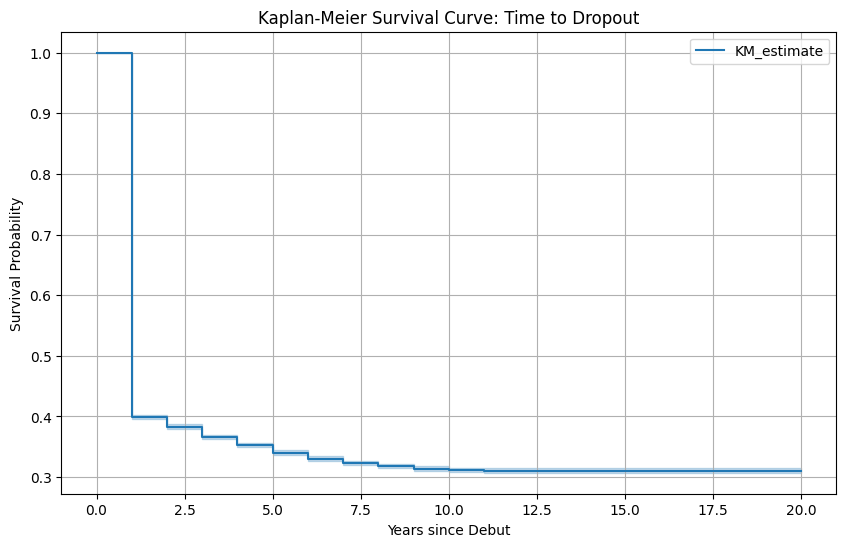

In [33]:
# Initialize the Kaplan-Meier Fitter from the lifelines library, a tool for survival analysis
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier model using the duration each director was observed and their dropout status
kmf.fit(durations=last_observation['last_year'], event_observed=last_observation['last_status'])

# Plot the Kaplan-Meier survival function to visualize the probability of directors staying active over time
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve: Time to Dropout')
plt.xlabel('Years since Debut')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

The curve initially shows a steep drop in survival probability within the first year after a director's debut, plummeting from a full 100% to around 40%. This drastic decrease suggests that about 60% of directors exit the industry relatively quickly, which might be attributed to various challenges such as securing new projects, financial constraints, or the intensely competitive nature of the film industry.

Following the steep initial decline, the survival curve gradually slopes downward at a less steep rate. This observation indicates that while the risk of dropping out remains present throughout a director's career, it becomes less acute after the initial few years. By the 10-year mark, the survival probability stabilizes around 30%, suggesting that those who overcome the initial hurdles may have somewhat steadier career trajectories.

This Kaplan-Meier curve not only sheds light on the high attrition rates in the early years of directing but also helps identify critical periods when directors are most vulnerable and might benefit from additional support. By understanding these dynamics, we can better appreciate the challenges faced by directors and consider strategies to enhance career sustainability in the film industry.

**Cohort Analysis**

Let's see if there are differences among directors entering the industry at different times.

In [37]:
# Calculate the last year observed and the last status for each director, grouped by director ID and debut year
last_observation_by_debut = filtered_data.groupby(['nconst_director', 'debut_year']).agg(
    last_year=('start_time', 'max'),  # The maximum 'start_time' gives the last year of data for each director
    last_status=('dropout', 'last')  # 'last' captures whether the director had dropped out by their last year of observation
).reset_index()

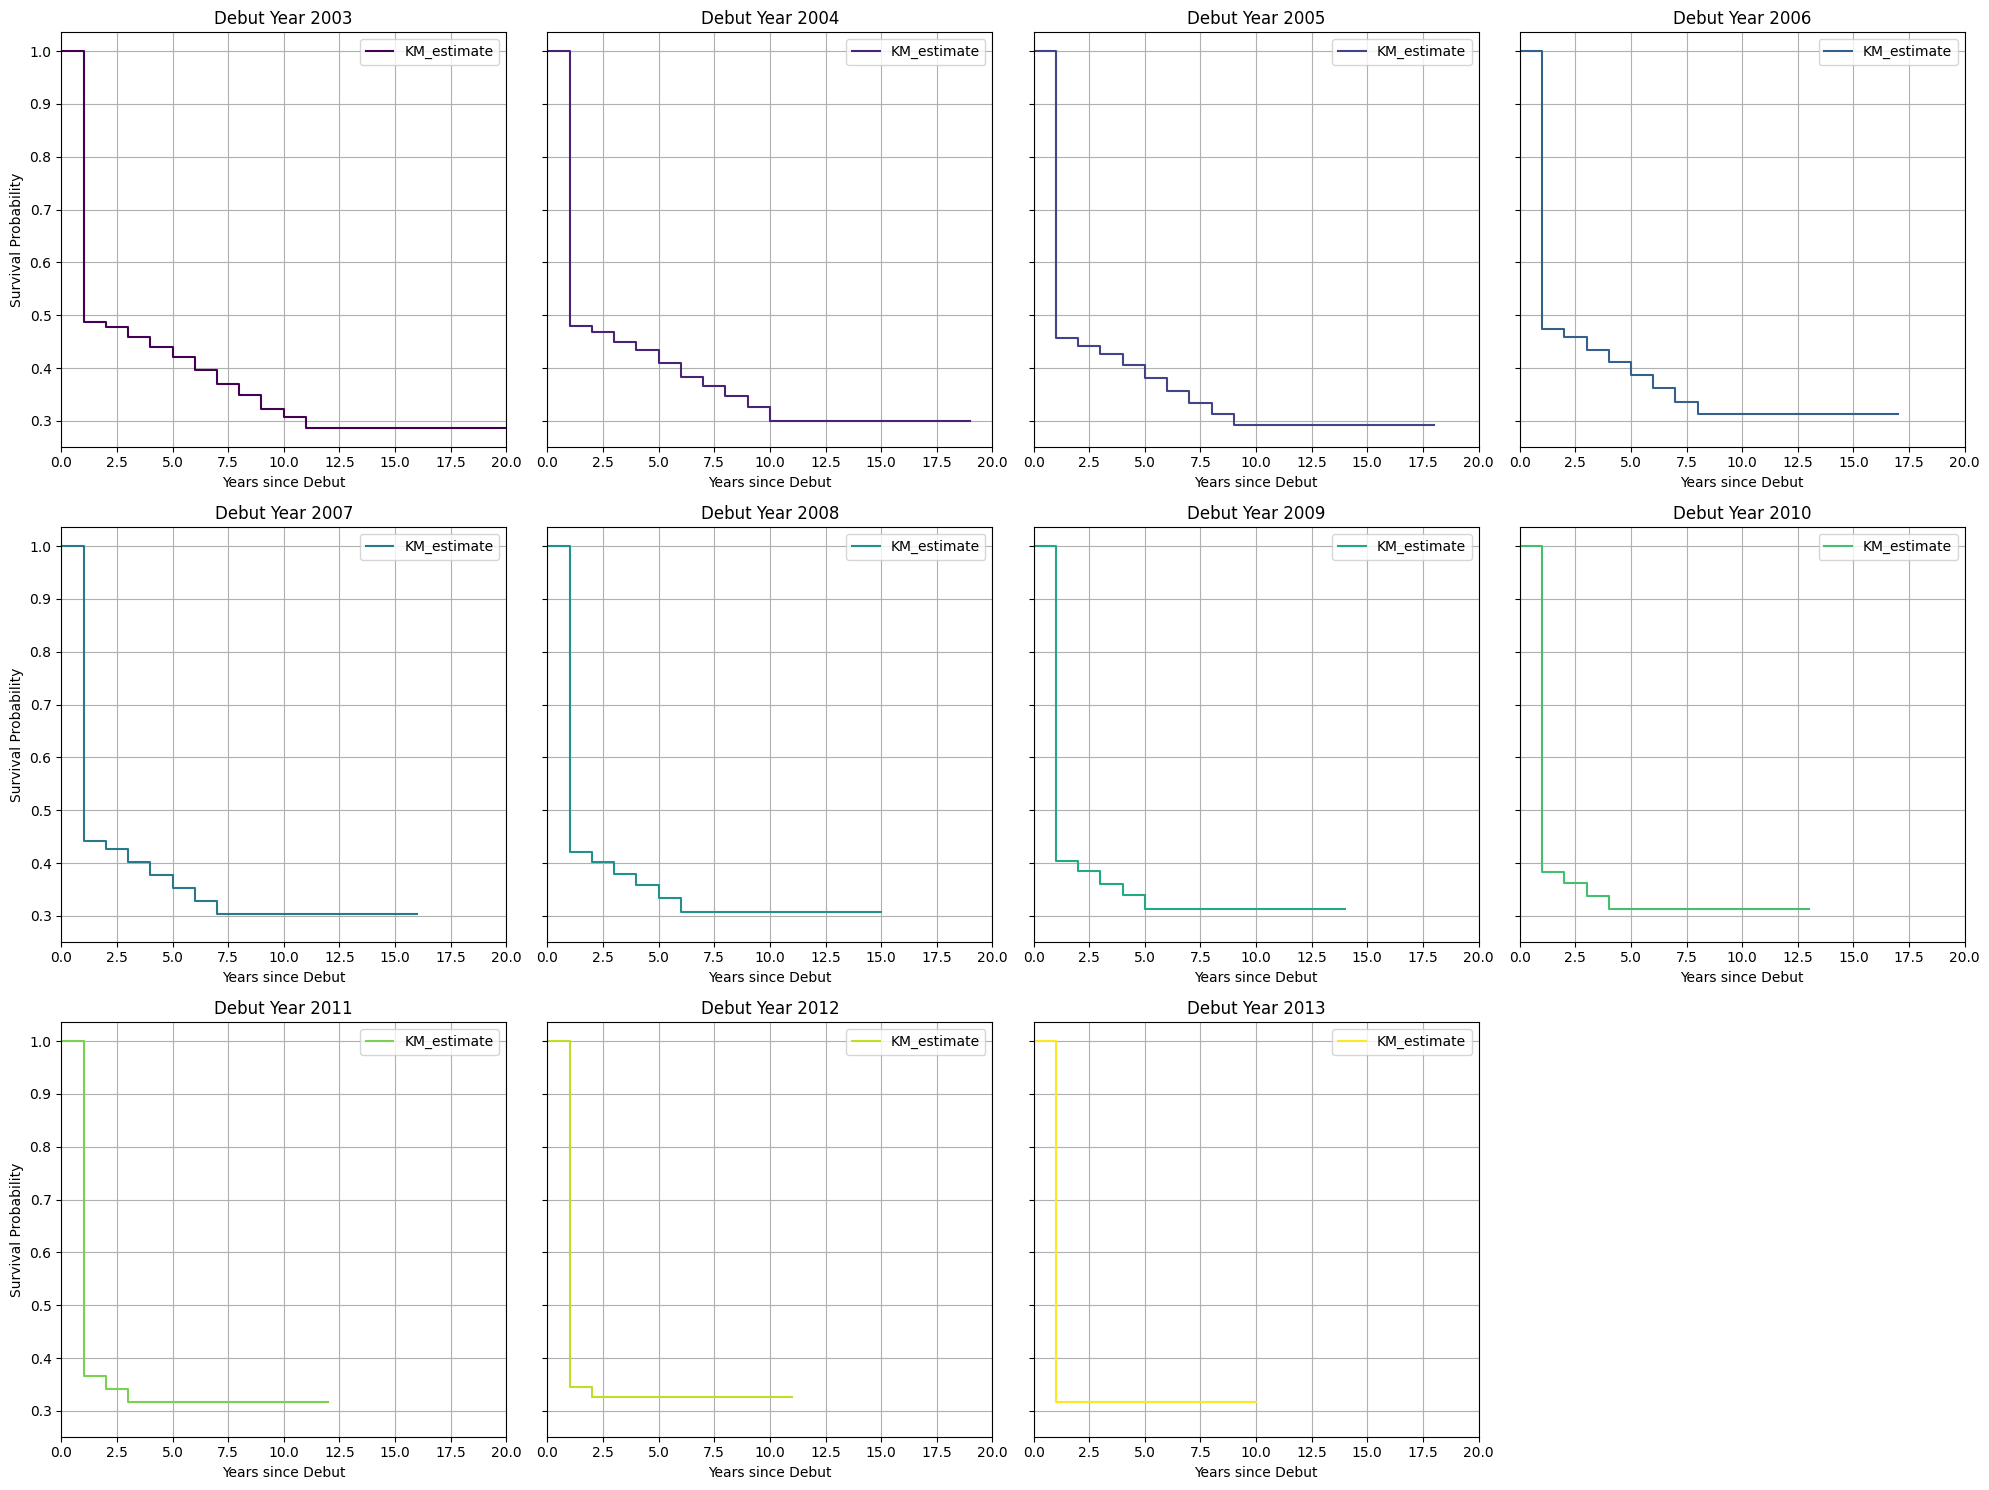

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from lifelines import KaplanMeierFitter

# Assuming last_observation is already prepared as instructed
# Sample last_observation DataFrame columns: ['nconst_director', 'debut_year', 'last_year', 'last_status']

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Get unique debut years and sort them
debut_years = sorted(last_observation_by_debut['debut_year'].unique())

# Define the number of plots per row
plots_per_row = 4

# Calculate number of rows needed (each row has 4 plots)
n_rows = (len(debut_years) + plots_per_row - 1) // plots_per_row

# Create subplots
fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(20, 5 * n_rows), sharey=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(debut_years)))

# Determine the maximum duration to set a consistent x-axis range
max_duration = last_observation_by_debut['last_year'].max()

# Loop through each debut year to plot its Kaplan-Meier curve
for i, year in enumerate(debut_years):
    ax = axes[i]
    # Subset data for the cohort
    cohort_data = last_observation_by_debut[last_observation_by_debut['debut_year'] == year]
    
    # Fit the Kaplan-Meier model
    kmf.fit(durations=cohort_data['last_year'], event_observed=cohort_data['last_status'])
    
    # Plot the survival function on the designated subplot
    kmf.plot_survival_function(ax=ax, color=colors[i], ci_show=False)
    ax.set_title(f'Debut Year {year}')
    ax.set_xlabel('Years since Debut')
    ax.set_ylabel('Survival Probability')
    ax.set_xlim(0, max_duration)  # Set the same x-axis limits for all subplots
    ax.grid(True)

# Hide unused subplots if not divisible by 4
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout for better fit
plt.tight_layout()
plt.show()


There is a peak in dropout rates during the second year across all cohorts. This trend reveals a harsh reality: many directors do not make a second movie following their debut, highlighting the competitive nature of this field. Despite this initial challenge, those who continue past their early hurdles tend to enjoy more sustainable careers. The dropout rates generally decline after this peak, suggesting a stabilization in career longevity for those who persist.

It's important to note that for newer cohorts, such as directors debuting in 2013, our data spans only 11 years. This limitation might skew the apparent dropout rates towards the end of our observation period, as directors active any time between 2014 and 2023 are considered still active. Therefore, while later years show a dropout rate nearing zero, this is more reflective of our study's time frame rather than a definitive end to directors' careers.

Moreover, direct comparisons between cohorts must be approached with caution. Cohorts with longer observation periods might show lower dropout rates simply because they've had more opportunities to direct films, potentially skewing comparative analyses.

# Creating cross-sectional dataset

Given the limitations with the different lengths of observation time across cohorts—we need to explore another analytical approach to validate our findings. We will create a cross-sectional dataset capturing detailed career information within the first 11 years of each director's career, starting from their debut. This dataset will allow us to control for different debut year since everyone has the same observation timeline. 

With this dataset, we'll investigate the time it takes for a director to release their second movie. It will include the following columns:
- `nconst_director`: A unique identifier for each director. 
- `debut_year`: The year in which a director released their first movie. 
- `time_to_second_movie`: The number of years from the director's debut to the release of their second movie. This is the primary variable of interest for survival analysis, indicating how quickly directors follow up their debut with another film. If a director has not released a second movie within the first 11 years, this is filled with an upper limit value (e.g., 11), representing censored data in survival analysis.
- `event`: A binary indicator coded as 1 if the second movie was made (non-censored), and 0 if the second movie was not made by the end of the study period (censored). This variable is essential for survival analysis, as it helps differentiate between directors who have reached the event of interest (second movie release) and those who have not within the study frame.
- `total_movies`: The total number of movies a director released within the first 11 years of their career.

In [ ]:
# Filter the data to include only the first 11 years of each director's career
filtered_data = directors_years[directors_years['start_time'] <= 10].copy()

# Calculate cumulative movies for each director over time
filtered_data['cumulative_movies'] = filtered_data.groupby('nconst_director')['num_movies'].cumsum()

# Determine the minimum year when cumulative movies reach or exceed 1 
# (meaning their second movie since we set 0 for number of movies in their debut year to focus on analyzing career after debut)
second_movie_time = filtered_data[filtered_data['cumulative_movies'] >= 1].groupby('nconst_director')['start_time'].min()

# Create a DataFrame from the second_movie_time series
second_movie_df = second_movie_time.reset_index()
second_movie_df.columns = ['nconst_director', 'time_to_second_movie']

# Retrieve all director IDs and their debut year
# Merge this with the second_movie_df to include all directors
# Directors without a second movie will have NaN in 'time_to_second_movie'
directors_cross_sectional = filtered_data[['nconst_director', 'debut_year']].drop_duplicates().merge(second_movie_df, on='nconst_director', how='left')

# Create event indicator
directors_cross_sectional['event'] = (~directors_cross_sectional['time_to_second_movie'].isna()).astype(int)  # 1 if second movie made, 0 if not

# Handling the time variable, using the maximum study period for those who didn't make a second movie:
directors_cross_sectional['time_to_second_movie'] = directors_cross_sectional['time_to_second_movie'].fillna(11)

In [ ]:
directors_cross_sectional

,nconst_director,debut_year,time_to_second_movie,event
0,nm1131265,2004,9.0,1
1,nm1130611,2004,11.0,0
2,nm0290651,2003,11.0,0
3,nm0404033,2003,5.0,1
4,nm0000417,2005,2.0,1
...,...,...,...,...
63164,nm4394847,2012,11.0,0
63165,nm10527671,2012,11.0,0
63166,nm10532602,2012,11.0,0
63167,nm4453202,2012,11.0,0


In [ ]:
# Calculate the total number of movies each director made within the first 11 years
total_movies = directors_years[directors_years['start_time'] < 11].groupby('nconst_director')['num_movies'].sum().reset_index()
total_movies.columns = ['nconst_director', 'total_movies']

# Merge this back to the main DataFrame to include all directors
directors_cross_sectional = directors_cross_sectional.merge(total_movies, on='nconst_director', how='left')

In [ ]:
directors_cross_sectional

,nconst_director,debut_year,time_to_second_movie,event,total_movies
0,nm1131265,2004,9.0,1,1.0
1,nm1130611,2004,11.0,0,0.0
2,nm0290651,2003,11.0,0,0.0
3,nm0404033,2003,5.0,1,1.0
4,nm0000417,2005,2.0,1,1.0
...,...,...,...,...,...
63164,nm4394847,2012,11.0,0,0.0
63165,nm10527671,2012,11.0,0,0.0
63166,nm10532602,2012,11.0,0,0.0
63167,nm4453202,2012,11.0,0,0.0


In [ ]:
directors_cross_sectional.to_csv("directors_cross_sectional.csv", index=False)